<a href="https://colab.research.google.com/github/modouktouray/farm_instrusion_detection/blob/main/farm_intrusion_detection_resNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
# Upload ZIP Files (Training and Testing Folders)
from google.colab import files


# Unzip the Files
import zipfile
import os

# Unzip the training data
train_zip_path = "train.zip"
test_zip_path = "test.zip"

# Extract training data
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train')

# Extract testing data
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/test')

# Verify Folder Structure
print("Training data contents:")
print(os.listdir('/content/train'))

print("\nTesting data contents:")
print(os.listdir('/content/test'))

Training data contents:
['train']

Testing data contents:
['test']


In [4]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import random

# Function to apply a night-time effect to an images
def apply_night_effect(image):
    """
    Simulates a night-time effect by reducing brightness and adding a bluish tint.
    """
    # Reduce brightness
    alpha = 0.6
    beta = -50
    darkened = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Add a bluish tint
    blue_tint = np.zeros_like(darkened)
    blue_tint[:, :, 0] = 50
    night_effect = cv2.addWeighted(darkened, 0.8, blue_tint, 0.2, 0)

    return night_effect

# Paths for input and output directories
train_dir = '/content/train/train'
output_dir = '/content/train_augmented'
os.makedirs(output_dir, exist_ok=True)

# Augment images for each class
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"Processing class: {class_name}")
    output_class_path = os.path.join(output_dir, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    # List all images in the current class folder
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_night_effects = len(image_files) // 2  # Augment 50% of the images

    # Randomly select images for augmentation
    random.shuffle(image_files)
    selected_images = image_files[:num_night_effects]

    # Apply night-time effect
    for img_file in tqdm(selected_images, desc=f"Augmenting {class_name}"):
        img_path = os.path.join(class_path, img_file)
        image = cv2.imread(img_path)

        night_image = apply_night_effect(image)

        # Save the augmented image
        output_path = os.path.join(output_class_path, img_file)
        cv2.imwrite(output_path, night_image)

    # Copy remaining images to the augmented folder
    for img_file in image_files[num_night_effects:]:
        img_path = os.path.join(class_path, img_file)
        output_path = os.path.join(output_class_path, img_file)
        image = cv2.imread(img_path)
        cv2.imwrite(output_path, image)

print("Night-time augmentation complete. Augmented dataset is ready.")


Processing class: humans


Augmenting humans: 100%|██████████| 450/450 [00:00<00:00, 651.42it/s]


Processing class: monkeys


Augmenting monkeys: 100%|██████████| 524/524 [00:13<00:00, 38.64it/s]


Night-time augmentation complete. Augmented dataset is ready.


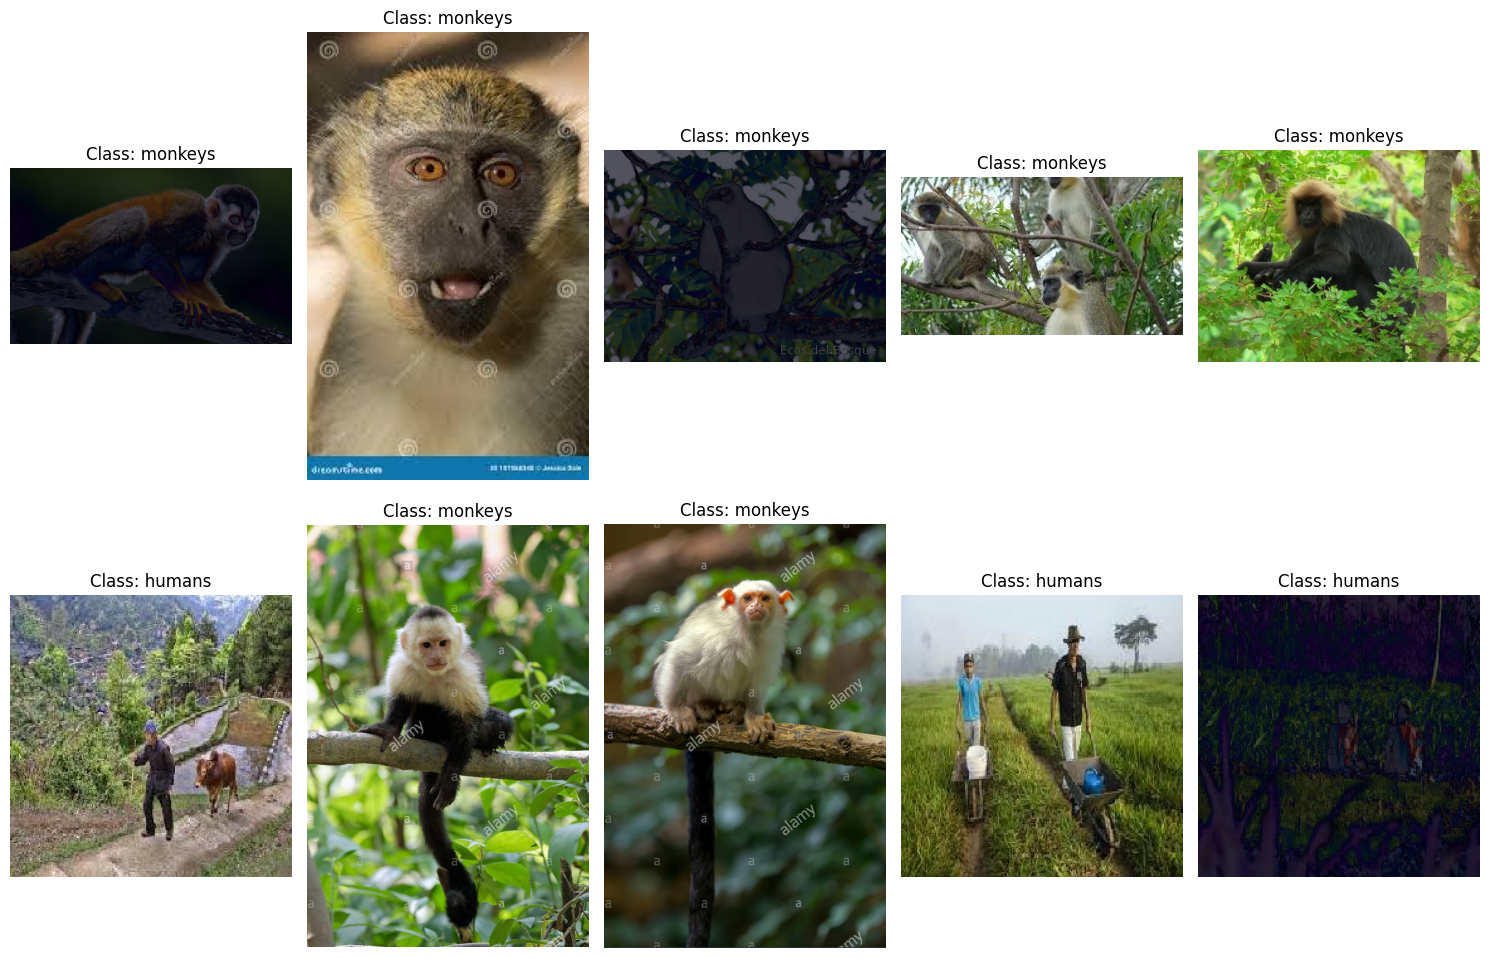

In [5]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Path to the augmented dataset
augmented_dir = '/content/train_augmented'

# Function to load and display images
def display_augmented_images(augmented_dir, num_images=10):
    """
    Display a specified number of randomly selected augmented images from the dataset.
    """
    all_images = []

    # Traverse the augmented dataset and collect file paths
    for class_name in os.listdir(augmented_dir):
        class_path = os.path.join(augmented_dir, class_name)
        if os.path.isdir(class_path):
            images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
            all_images.extend(images)

    # Randomly select images to display
    selected_images = random.sample(all_images, min(num_images, len(all_images)))

    # Display images
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(selected_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        plt.subplot(2, 5, i + 1)  # Create a grid for 10 images
        plt.imshow(img)
        plt.title(f"Class: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to display augmented images
display_augmented_images(augmented_dir, num_images=10)


In [6]:

# Set Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data
train_generator = train_datagen.flow_from_directory(
    '/content/train/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Test data
test_generator = test_datagen.flow_from_directory(
    '/content/test/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Define the Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze the base model layers

# Add a classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Step 4: Train the Model
history = model.fit(
    train_generator,
    epochs=EPOCHS
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate Predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Test on a Single Image (Optional)
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_single_image(image_path, model, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)
    predicted_class = int(prediction > 0.5)
    class_name = class_labels[predicted_class]

    print(f"The image '{image_path}' is predicted as '{class_name}' with confidence {prediction[0][0]:.2f}")
    return class_name

# Example usage of single image prediction
# predict_single_image('/content/test/humans/sample_image.jpg', model, class_labels)


Found 1949 images belonging to 2 classes.
Found 398 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 431s 7s/step - accuracy: 0.4911 - loss: 0.8873
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 427s 7s/step - accuracy: 0.5358 - loss: 0.7048
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 430s 7s/step - accuracy: 0.5424 - loss: 0.7077
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 421s 7s/step - accuracy: 0.5317 - loss: 0.6956
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 444s 7s/step - accuracy: 0.5426 - loss: 0.6980
Epoch 6/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 440s 7s/step - accuracy: 0.5638 - loss: 0.6817
Epoch 7/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 442s 7s/step - accuracy: 0.5403 - loss: 0.6912
Epoch 8/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 443s 7s/step - accuracy: 0.5599 - loss: 0.6769
Epoch 9/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 440s 7s/step - accuracy: 0.5490 - loss: 0.6857
Epoch 10/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 444s 7s/step - accuracy: 0.6177 - loss: 0.6647
Epoch 11/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 443s 7s/step - accuracy: 0.5877 - loss: 0.6696
Epoch 12/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 419s 7s/step - accuracy: 0.5933 - l

NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>

KeyError: 'val_accuracy'

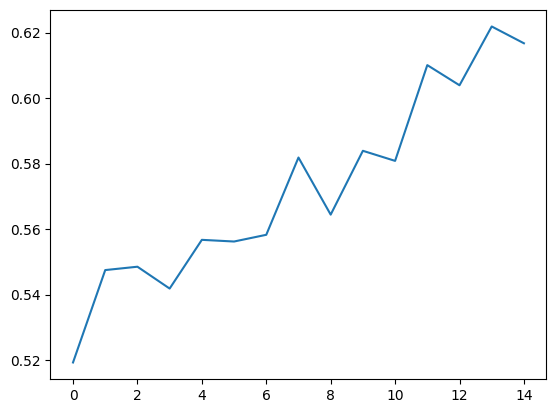

In [7]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


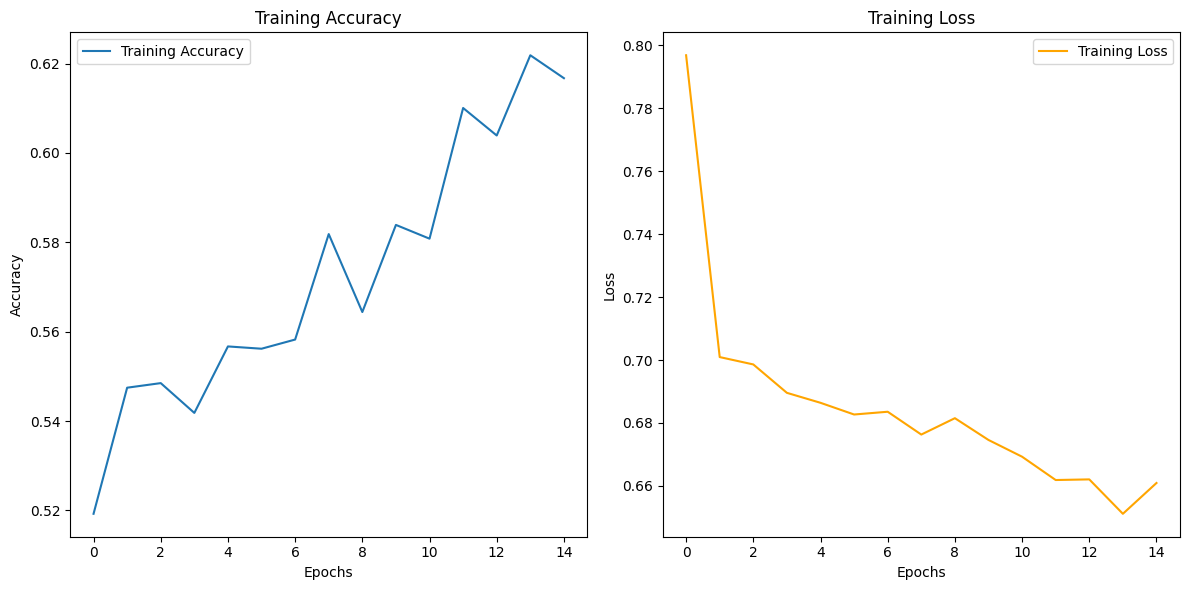

In [8]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """
    Plot training and validation accuracy and loss curves.

    Args:
        history: Training history object from model.fit().
    """
    # Accuracy plot
    plt.figure(figsize=(12, 6))

    # Plot training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='orange')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(history)


In [ ]:
model.save('/content/restNet50_model.h5')
print("Model saved as restNet50_model.h5")